# Семинар 4: Методы оптимизации, PyTorch Lightning

## Вступление
На предыдущем курсе мы обсуждали с вами методы градиентного спуска и стохастического градиентного спуска. Для нейронных сетей обычно используют более продвинутые методы оптимизации, которые основаны на известном нам градиентном спуске. Сегодня мы посмотрим на то, как использовать их в **PyTorch**, а также разберём библиотеку **PyTorch Lightning**, позволяющую сократить количество кода, которое нам приходится писать на **PyTorch**.

### План семинара
1. Оптимизируем функцию одной переменной в **PyTorch**
2. Изучаем разные методы оптимизации
3. Работаем с PyTorch Optimizer
4. Работаем с PyTorch Scheduler
5. PyTorch VS PyTorch Lightning
6. Сравнением работу разных оптимизаторов

In [ ]:
#!pip3 install pytorch_lightning torchmetrics torchvision

In [ ]:
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

In [ ]:
def seed_everything(seed):
    # фискирует максимум сидов для корректности сравнения разных экспериментов
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(0xBADBEEF)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Оптимизируем функцию одной переменной в **PyTorch**
Как вам показали на лекции, большинство методов машинного обучения сводятся к простому поиску параметров, который бы минимизировал ошибку на тренировочной выборке:
$$
\min_{\theta}L(p_{\theta}(X), Y)
$$
Здесь:
* $L$ - некоторый лосс,
* $p_{\theta}$ - нейронная сеть с параметрами $\theta$
* $X$ - данные для обучения,
* $Y$ - ответы

Давайте руками напишем алгоритм для поиска минимума функции $f(x) = x^{3} - 2x^{2} + 2$.

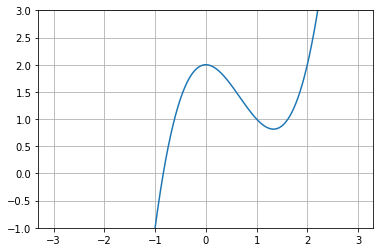

In [ ]:
# наша функция f(x)
func = lambda x: x**3 - 2 * x**2 + 2
# производная функции f(x)
d_func = lambda x: 3 * x**2 - 4 * x
# сделаем массив из 1000 элементов от -3 до 3
x = np.linspace(-3, 3, 1000)
# определим границы по y для графика
plt.ylim([-1, 3])
plt.plot(x, func(x))
plt.grid()
plt.show()

Определим функцию для оптимизации $f(x)$, которая должна принимать на вход learning rate и максимальное количество итераций.

In [ ]:
def find_minimum_first_order(
    learning_rate=0.01, eps=1e-4, max_iterations=1000, anneal_learning_rate=None
):
    i = 0
    x_old, x_new = 0, 2
    # будем сохранять историю значений x и y
    x_list, y_list = [x_old], [func(x_old)]
    if not anneal_learning_rate:
        anneal_learning_rate = lambda lr, step: lr
    # TODO:
    # Your code here
    # --------------
    while abs(x_new - x_old) > eps and i < max_iterations:
        # получим learning rate для текущей итерации
        learning_rate = anneal_learning_rate(learning_rate, step=i)
        # обновим x_old
        x_old = x_new
        # сделаем один шаг gradient descent
        x_new = x_old - learning_rate * d_func(x_old)
        # добавим новые значения для визуализации сходимости
        x_list.append(x_new)
        y_list.append(func(x_new))
        i += 1
    # --------------
    print("Найденный локальный минимум:", x_new)
    print("Количество шагов:", len(x_list))
    # Визуализируем сходимость
    plt.figure(figsize=[6, 4])
    plt.ylim([-3, 8])
    plt.scatter(x_list, y_list, c="r", edgecolors="k")
    plt.plot(x_list, y_list, c="r")
    plt.plot(x, func(x), c="b")
    plt.title("Descent trajectory")
    plt.grid()
    plt.show()

Попробуем различные `learning_rate` и посмотрим на поведение оптимизации.

Найденный локальный минимум: 1.3577577123861129
Количество шагов: 729


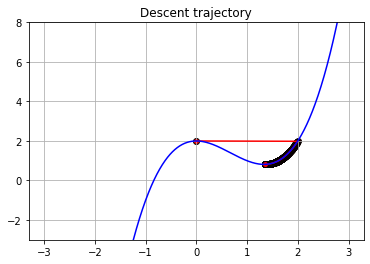

In [ ]:
find_minimum_first_order(0.001)

Слишком мало, будем очень долго идти к локальному минимуму.

Найденный локальный минимум: 1.3356881625009205
Количество шагов: 129


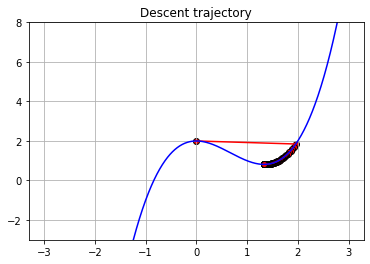

In [ ]:
find_minimum_first_order(0.01)

Уже лучше.

Найденный локальный минимум: 1.3333495713163788
Количество шагов: 8


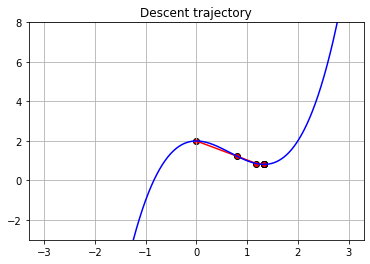

In [ ]:
find_minimum_first_order(0.3)

In [ ]:
find_minimum_first_order(0.6)

OverflowError: (34, 'Result too large')

Ууупс, получили Overflow. Значит learning rate слишком большой. Хотя большой learning rate опасен возможностью overflow у него есть ряд преимуществ. Чем больше темп обучения, тем большие расстояния мы преодолеваем за один шаг и тем выше вероятность быстрее найти хорошее пространство локальных минимумов.

Хорошая стратегия — начинать с достаточно большого шага (чтобы хорошо попутешествовать по функции), а потом постепенно его уменьшать, чтобы стабилизировать процесс обучения в каком-то локальном минимуме.

In [ ]:
find_minimum_first_order(0.6, anneal_learning_rate=lambda lr, step: 0.3 * lr)

## Изучаем разные методы оптимизации

### Stochastic Gradient Descent
SGD - этот же самый gradient descent, что мы рассматривали ранее, но подсчёт градиентов производится не по всему множеству данных, а по отдельно взятому сэмплу. Очевидно, такая оптимизация будет очень шумной, что усложнит обучение модели. Поэтому обычно используют MiniBatch-SGD, где вместо одного сэмпла мы берём $k$. У такого подхода ниже variance в сравнении с обычным SGD, что приводит к более стабильному процессу оптимизации. В том эе время нам всё ещё не нужно работать со всей выборкой одновременно, поэтому мы можем контролировать используемую память.

$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
w &=& w - \eta \times g
\end{eqnarray}
$$

### Stochastic Gradient Descent with Momentum
Попытаемся добавить SGD эффект инерции. Теперь, вместо того чтобы двигаться строго в направлении градиента в каждой точке, мы стараемся продолжить движение в том же направлении, в котором двигались ранее. То есть у нашей точки, которая спускается по многомерной поверхности, появляется импульс (momentum), который контролируется при помощи параметра $\alpha$. Он определяет какую часть прошлого градиента мы хотим использовать на текущем шаге.
$$
\begin{eqnarray}
g_{t} &=& \alpha g_{t-1} + \eta \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
w &=& w - \eta \times g
\end{eqnarray}
$$

![Momentum](https://github.com/hse-ds/iad-deep-learning/blob/master/2022/seminars/sem04/static/sgd_momentum.png?raw=1)

### Адаптивные варианты градиентного спуска
Во всех предыдущих алгоритмах у нас был фиксированный learning rate. Начиная с Adagrad у нас будет идти алгоритмы, которые подстраивают learning rate в зависимости от обучения. Они называются адаптивными вариантами градиентного спуска.

Адаптивные варианты градиентного спуска подстраивает темп обучения таким образом, чтобы делать большие или маленькие обновления отдельных параметров. Например, может так сложиться, что некоторые веса близки к своим локальным минимумам, тогда по этим координатам нужно двигаться медленнее, а другие веса ещё только в середине, значит их можно менять гораздо быстрее. Подобные методы часты приводят к более обоснованной модели и сходятся гораздо быстрее.

#### Adagrad
$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
s &=& s + diag(gg^{T}) \\
w &=& w - \frac{\eta}{\sqrt{s+eps}} \odot g
\end{eqnarray}
$$
Теперь нам не нужно сильно волноваться о правильном подборе $\eta$, так как $s$ контролирует скорость обучения для каждого параметра.

#### RMSprop
У Adagrad есть сильный минус. $s$ - всегда положительна и постоянно растёт во время обучения, что приводит к ситуации, когда у нас learning rate становится слишком маленький, и мы перестаём учиться. RMSprop исправляет эту проблему при помощи экспоненциального сглаживания:

$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
s &=& \rho s + (1 - \rho) diag(gg^{T}) \\
w &=& w - \frac{\eta}{\sqrt{s+eps}} \odot g
\end{eqnarray}
$$

#### Adam
Добавим не только моменты второго порядка, но и первого при обновлении параметров:

$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

#### Схема
![Sheme](https://github.com/hse-ds/iad-deep-learning/blob/master/2022/seminars/sem04/static/gd_scheme.png?raw=1)

### Работаем с PyTorch Optimizer

Очевидно, что для своих нейронных сетей не нужно каждый раз писать свой алгоритм и за вас уже сделаны все самые популярные методы. Их можно найти в **torch.optim** или по [ссылке](https://pytorch.org/docs/stable/optim.html#algorithms).

In [ ]:
[elem for elem in dir(torch.optim) if not elem.startswith("_")]

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 'lr_scheduler',
 'swa_utils']

Основные методы PyTorch Optimizer:
* __step__ - обновление весов модели
* __zero_grad__ - занулить веса модели (по умолчанию градиенты в PyTorch аккумулируются) ~ `for each param in params: param.grad = None`
* __state_dict__ - получить текущее состояние Optimizer. Для адаптивных методов тут будут храниться аккумулированные квадраты градиентов


### Как создать инстанс PyTorch Optimizer?

Для того чтобы создать инстанс оптимизатора, достаточно передать ему параметры модели (их можно получить при помощи функции `parameters()`) и гиперпараметры для метода оптимизации.

Пример:

In [ ]:
?torch.optim.SGD

In [ ]:
model = torch.nn.Linear(1, 1)
list(model.named_parameters()), torch.optim.SGD(model.parameters(), lr=0.01)

([('weight',
   Parameter containing:
   tensor([[-0.1194]], requires_grad=True)),
  ('bias',
   Parameter containing:
   tensor([0.4259], requires_grad=True))],
 SGD (
 Parameter Group 0
     dampening: 0
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

Или же вот так:

In [ ]:
# Зададим PyTorch модули в качестве словаря
model = torch.nn.ModuleDict(
    {"linear_1": torch.nn.Linear(1, 1), "linear_2": torch.nn.Linear(2, 2)}
)
torch.optim.SGD(
    [
        {"params": model["linear_1"].parameters(), "lr": 0.3},
        {"params": model["linear_2"].parameters()},
    ],
    lr=0.5,
)

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.3
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    foreach: None
    lr: 0.5
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

Последнее очень полезно, например, для transfer learning, когда мы хотим, чтобы предобученная модель тренировалась с другим learning rate.

**Важный момент:** даже если у вас есть методы с адаптивным градиентом спуском, полностью забывать о настройке learning rate не стоит.

### Работаем с PyTorch Scheduler

В начале семинара мы уменьшили количество шагов до сходимости следующим образом: начали с достаточно большого шага, а потом постепенно его уменьшили, чтобы стабилизировать процесс обучения в минимуме. Оказывается есть много способов менять оптимизацию таким образом. Они называются Schedulers.

In [ ]:
[elem for elem in dir(torch.optim.lr_scheduler) if not elem.startswith("_")]

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'EPOCH_DEPRECATION_WARNING',
 'ExponentialLR',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR',
 'bisect_right',
 'inf',
 'math',
 'types',
 'warnings',
 'weakref',
 'wraps']

Основные методы PyTorch Scheduler:
* __step__ - обновление размера шага. *Обычно вызывается **1 раз за эпоху**, а не каждый шаг оптимизатора.*
* __state_dict__ - получить текущее состояние Scheduler: текущий LR, количество пройденных шагов и дополнительные параметры.


### Как создать инстанс PyTorch Scheduler?

Достаточно передать `optimizer` и гиперпараметры для метода.

Пример:

In [ ]:
model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler_func = lambda epoch: 0.65**epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, scheduler_func)

Сделаем пару небольших функций для отрисовки изменения шага обучения на разных шедулерах:

In [ ]:
def get_simple_model_optimizer():
    simple_model = torch.nn.Linear(2, 1)
    simple_optimizer = torch.optim.SGD(model.parameters(), lr=100)
    return simple_model, simple_optimizer


def draw_learning_rate_curve(optimizer, scheduler):
    lrs = []
    for i in range(100):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
    plt.grid()
    plt.plot(range(100), lrs)

### Примеры различных шедулеров в **PyTorch**

#### Lambda LR
Умножает шаг на значение данной ему функции: $lr_{epoch} = lr_{initial} * Lambda(epoch)$.

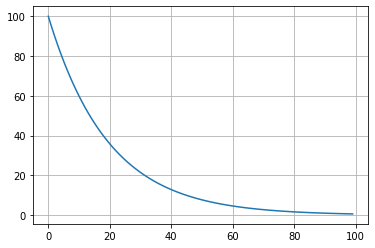

In [ ]:
model, optimizer = get_simple_model_optimizer()
lambda_func = lambda epoch: 0.95**epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)
draw_learning_rate_curve(optimizer, scheduler)

#### StepLR
Каждые `step_size` эпох уменьшает LR в `gamma` раз.

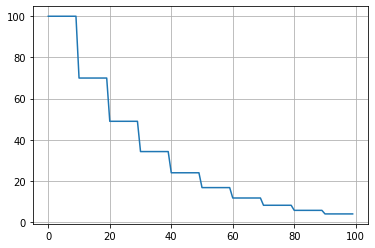

In [ ]:
model, optimizer = get_simple_model_optimizer()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
draw_learning_rate_curve(optimizer, scheduler)

#### CosineAnnealingLR

Важно понимать, что LR имеет смысл не только снижать, но иногда еще и делать цикличным. Формула тут несколько сложнее, оставим ее для интересующихся)

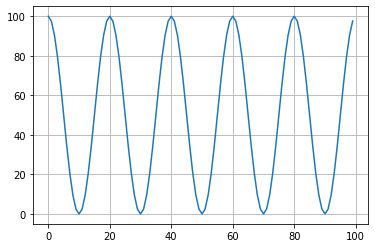

In [ ]:
model, optimizer = get_simple_model_optimizer()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
draw_learning_rate_curve(optimizer, scheduler)

## PyTorch VS PyTorch Lightning

**PyTorch Lightning** это фреймворк для организованной работы с **PyTorch**. В нем упрощена работа по:
- Написанию тренировочного цикла
- Написанию датасетов
- Использованию gpu/tpu/ipu/hpu и тд
- Переводу моделей в формат ONNX
- И многому другому

Фреймворк призван оставить юзеру возможность конфигурировать параметры и проводить эксперименты, а остальное он возьмет на себя. Давайте сравним код на **PyTorch** без и с использованием **Lightning** на примере несложной нейросети на датасете FashionMNIST.

In [ ]:
from collections import defaultdict, namedtuple

import pytorch_lightning as pl
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# крутая библиотека с кучей метрик "из коробки"
from torchmetrics.functional import accuracy

### Данные (общее)

In [ ]:
# Train data
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    "./data", download=True, transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = DataLoader(
    fashion_mnist_train, batch_size=128, shuffle=True, num_workers=4
)

# Validation data
fashion_mnist_val = torchvision.datasets.FashionMNIST(
    "./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)
val_dataloader = DataLoader(fashion_mnist_val, batch_size=128, num_workers=4)

In [ ]:
idx_to_label = defaultdict(
    None,
    {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    },
)

Ankle Boot


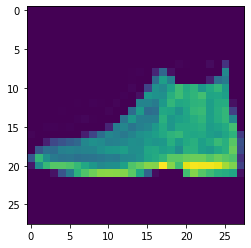

Coat


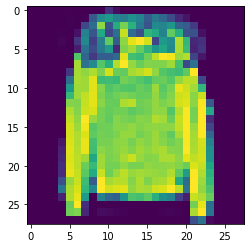

In [ ]:
### pictures are normalized
for batch in val_dataloader:
    # batch_size is 128
    images, class_nums = batch
    print(idx_to_label[int(class_nums[0])])
    plt.imshow(images[0].squeeze())
    plt.show()
    print(idx_to_label[int(class_nums[127])])
    plt.imshow(images[127].squeeze())
    plt.show()
    break

### Модель (общее)

Создайте класс модели по следующей схеме:

1. BatchNorm
2. Conv(out=32, kernel=3) -> ReLu -> MaxPool(kernel=2)
3. BatchNorm
4. Conv(out=64, kernel=3) -> ReLu -> MaxPool(kernel=2)
5. Flatten
6. Linear(out=128)
7. ReLu
8. Dropout
9. Linear(out=64)
10. ReLu
11. Linear(out=10)

In [ ]:
class SimpleNet(torch.nn.Module):
    def __init__(self, dropout=0.4):
        super().__init__()
        # TODO:
        # Your code here:
        # --------------
        self.batch_norm1 = torch.nn.BatchNorm2d(1)

        self.relu = torch.nn.ReLU()

        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            self.relu,
            self.maxpool,
        )
        self.batch_norm2 = torch.nn.BatchNorm2d(32)

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            self.relu,
            self.maxpool,
        )

        self.linear1 = torch.nn.Linear(in_features=64 * 5 * 5, out_features=128)
        self.linear2 = torch.nn.Linear(in_features=128, out_features=64)

        self.output = torch.nn.Linear(in_features=64, out_features=10)

        self.dropout = torch.nn.Dropout(p=dropout)

        # --------------
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        # runs the neural network
        # TODO:
        # Your code here
        # --------------
        x = self.batch_norm1(x)
        x = self.conv1(x)

        x = self.batch_norm2(x)
        x = self.conv2(x)

        x = x.view(x.size(0), -1)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))

        return self.output(x)
        # --------------

    def forward(self, images, target=None):
        # images ~ (batch size, num channels, height, width)
        # target ~ (batch size)
        # output ~ (batch size, num classes)
        output = self._forward(images)

        # get accuracy score and save it to self.accuracy
        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long(), task='multiclass', num_classes=10)

        return loss if target is not None else output

    def get_accuracy(self, reset=False):
        # return accuracy by all values till now
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

### Гиперпараметры

In [ ]:
LossInfo = namedtuple(
    "LossInfo", ["full_train_losses", "train_epoch_losses", "eval_epoch_losses"]
)
EPOCHS = 10
LR = 0.001

### Тренировочные циклы (PyTorch)

Здесь нам надо будет объявить функции `train_epoch`, `validate`, `fit`.
Структура, напомним, выглядит, в упрощенном виде, так:
```
def train_epoch():
    for batch in train_loader:
        train_model_on_batch()
def validate():
    for batch in val_loader:
        validate_model_on_batch()
def fit():
    for epoch in range(1, num_epochs):
        train_epoch()
        validate()
```
Но на деле это все намного сложнее:

In [ ]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    return_losses=False,
    device="cuda:0",
):
    model = model.train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            # move Batch to GPU
            batch = [x.to(device=device) for x in batch]
            loss = model(*batch)
            # update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # update description for tqdm
            accuracy = model.get_accuracy()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
            all_losses.append(loss.detach().item())
    acc = model.get_accuracy(reset=True)
    metrics = {"loss": total_loss / num_batches, "accuracy": acc}
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            batch = [x.to(device=device) for x in batch]
            loss = model(*batch)
            accuracy = model.get_accuracy()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
    acc = model.get_accuracy(reset=True)
    metrics = {"loss": total_loss / num_batches, "accuracy": acc}
    return metrics

In [ ]:
def fit(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    optimizer,
    scheduler=None,
    device="cuda:0",
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        # construct iterators
        train_iterator = iter(train_data_loader)
        validation_iterator = iter(validation_data_loader)
        # train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_iterator,
            optimizer=optimizer,
            return_losses=True,
            device=device,
        )
        # save train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        # eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model, data_loader=validation_iterator, device=device
            )
        # save eval losses
        epoch_eval_losses.append(validation_metrics["loss"])
        # scheduler step
        if scheduler:
            scheduler.step()
    return LossInfo(all_train_losses, epoch_train_losses, epoch_eval_losses)

In [ ]:
# проверим, что всё работает (±1 минута на гпу):
model = SimpleNet().to(device)
_ = fit(
    model=model,
    epochs=1,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.SGD(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 2.1868 Accuracy: 24.435: 100%|██████████| 469/469 [00:52<00:00,  8.95it/s] 
Validation Epoch: 0
Loss: 2.1573 Accuracy: 52.09: 100%|██████████| 79/79 [00:03<00:00, 21.25it/s]  


### Тренировочные циклы (Lightning)

Здесь будет немного другая структура.

1) Создается 1 класс отнаследованный от `pl.LightningModule`. В нем описывается сама модель, необходимые функции тренировчного и валидационного шага.

2) Создается объект класса `pl.Trainer` с параметрами (напр. номер гпу, кол-во эпох, град. клиппинг и так далее) дока [тут](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer) или [тут](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html?highlight=trainer#trainer-flags).

3) Вызывается `trainer.fit(model, train_loader, val_loader)`.


```
class MyModule(pl.LightningModule):
    def init():
        init_model()
    def forward():
        forward_model()
    def training_step():
        make_1_training_step()
    def validation_step():
        make_1_validation_step()

trainer = pl.Trainer(gpus=1, max_epochs=10)
trainer.fit(model, train_loader, val_loader)
```
Поскольку у нас уже есть модель `SimpleNet`, то исправлять нам много не надо.

In [ ]:
# 1) create a LightningModule
class SimpleModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        result = self.model(x)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        loss = self.model(images, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )  # сохраняет логи в папку, но можно несложно добавить wandb
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        loss = self.model(images, target)
        self.log("val_loss", loss, prog_bar=True)

In [ ]:
# 2) create module

model = SimpleNet().to(device)
module = SimpleModule(model, learning_rate=LR)

# 3) create Trainer and train (±30 seconds on gpu)
trainer = pl.Trainer(accelerator="cpu", max_epochs=1)
trainer.fit(module, train_dataloader, val_dataloader)

# 3.5) we can also find best learning rate like this: https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html
# trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)
# trainer.tune(module, train_dataloader, eval_dataloader)
# trainer.fit(module, train_dataloader, eval_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleNet | 232 K 
------------------------------------
232 K     Trainable params
0         Non-trainable params
232 K     Total params
0.931     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Обратите внимание **насколько** поведение `trainer.fit()` сильно похоже на написанную нами ранее функцию `fit()`


Заметьте также, что на Lightning мы:
1.   Не описывали тренировочный цикл ни по эпохам, ни по батчам
2.   Не рисковали забыть zero_grad, .backward()
3.   Не переносили ни модель, ни данные на GPU
4.   Получили всякие приколы типа auto_lr_find
5.   Сохранили возможность использования многих тонкостей **PyTorch** типа [schedulers](https://pytorch-lightning.readthedocs.io/en/stable/common/optimization.html), логирование через [wandb](https://docs.wandb.ai/guides/integrations/lightning) и так далее

## Сравнением работу разных оптимизаторов

### SGD

In [ ]:
model = SimpleNet().to(device=device)
sgd_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.SGD(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 2.218 Accuracy: 21.585: 100%|██████████| 469/469 [00:42<00:00, 11.15it/s]  
Validation Epoch: 0
Loss: 2.1814 Accuracy: 32.95: 100%|██████████| 79/79 [00:03<00:00, 22.48it/s]  
Train Epoch: 1
Loss: 1.9944 Accuracy: 35.3583: 100%|██████████| 469/469 [01:03<00:00,  7.34it/s]
Validation Epoch: 1
Loss: 1.919 Accuracy: 44.74: 100%|██████████| 79/79 [00:03<00:00, 22.70it/s]   
Train Epoch: 2
Loss: 1.5599 Accuracy: 46.68: 100%|██████████| 469/469 [00:51<00:00,  9.14it/s]  
Validation Epoch: 2
Loss: 1.4015 Accuracy: 59.52: 100%|██████████| 79/79 [00:03<00:00, 20.05it/s]  
Train Epoch: 3
Loss: 1.2538 Accuracy: 56.0033: 100%|██████████| 469/469 [00:55<00:00,  8.46it/s]
Validation Epoch: 3
Loss: 0.9758 Accuracy: 66.26: 100%|██████████| 79/79 [00:03<00:00, 20.19it/s]  
Train Epoch: 4
Loss: 1.1181 Accuracy: 61.475: 100%|██████████| 469/469 [00:52<00:00,  8.97it/s] 
Validation Epoch: 4
Loss: 0.7699 Accuracy: 69.0: 100%|██████████| 79/79 [00:03<00:00, 20.03it/s]   
Train Epoch: 5


### SGD with Momentum

In [ ]:
model = SimpleNet().to(device=device)
sgd_momentum_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.SGD(model.parameters(), momentum=0.9, lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 0.5944 Accuracy: 55.52: 100%|██████████| 469/469 [00:50<00:00,  9.35it/s]  
Validation Epoch: 0
Loss: 0.4246 Accuracy: 74.82: 100%|██████████| 79/79 [00:03<00:00, 21.18it/s]  
Train Epoch: 1
Loss: 0.5327 Accuracy: 75.79: 100%|██████████| 469/469 [00:49<00:00,  9.43it/s]  
Validation Epoch: 1
Loss: 0.3275 Accuracy: 78.84: 100%|██████████| 79/79 [00:03<00:00, 21.75it/s]  
Train Epoch: 2
Loss: 0.4683 Accuracy: 79.715: 100%|██████████| 469/469 [00:49<00:00,  9.57it/s] 
Validation Epoch: 2
Loss: 0.2871 Accuracy: 81.73: 100%|██████████| 79/79 [00:03<00:00, 21.65it/s]  
Train Epoch: 3
Loss: 0.4233 Accuracy: 82.56: 100%|██████████| 469/469 [00:49<00:00,  9.50it/s]  
Validation Epoch: 3
Loss: 0.236 Accuracy: 83.76: 100%|██████████| 79/79 [00:03<00:00, 21.84it/s]   
Train Epoch: 4
Loss: 0.4042 Accuracy: 84.3933: 100%|██████████| 469/469 [00:49<00:00,  9.49it/s]
Validation Epoch: 4
Loss: 0.231 Accuracy: 85.17: 100%|██████████| 79/79 [00:03<00:00, 21.93it/s]   
Train Epoch: 5


### RMSprop

In [ ]:
model = SimpleNet().to(device=device)
rmsprop_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.RMSprop(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 0.3617 Accuracy: 78.6683: 100%|██████████| 469/469 [00:54<00:00,  8.53it/s]
Validation Epoch: 0
Loss: 0.15 Accuracy: 85.54: 100%|██████████| 79/79 [00:04<00:00, 17.13it/s]    
Train Epoch: 1
Loss: 0.3588 Accuracy: 86.29: 100%|██████████| 469/469 [00:49<00:00,  9.54it/s]  
Validation Epoch: 1
Loss: 0.0937 Accuracy: 88.55: 100%|██████████| 79/79 [00:03<00:00, 23.46it/s]  
Train Epoch: 2
Loss: 0.2811 Accuracy: 88.0283: 100%|██████████| 469/469 [00:50<00:00,  9.37it/s]
Validation Epoch: 2
Loss: 0.1081 Accuracy: 88.95: 100%|██████████| 79/79 [00:03<00:00, 22.04it/s]  
Train Epoch: 3
Loss: 0.2266 Accuracy: 89.265: 100%|██████████| 469/469 [00:51<00:00,  9.15it/s] 
Validation Epoch: 3
Loss: 0.0954 Accuracy: 89.64: 100%|██████████| 79/79 [00:03<00:00, 21.26it/s]  
Train Epoch: 4
Loss: 0.3307 Accuracy: 89.8933: 100%|██████████| 469/469 [00:53<00:00,  8.74it/s]
Validation Epoch: 4
Loss: 0.0928 Accuracy: 89.78: 100%|██████████| 79/79 [00:03<00:00, 21.36it/s]  
Train Epoch: 5


### Adam

In [ ]:
model = SimpleNet().to(device=device)
adam_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 0.4804 Accuracy: 80.7233: 100%|██████████| 469/469 [00:56<00:00,  8.33it/s]
Validation Epoch: 0
Loss: 0.1099 Accuracy: 87.01: 100%|██████████| 79/79 [00:03<00:00, 19.86it/s]  
Train Epoch: 1
Loss: 0.4257 Accuracy: 87.6333: 100%|██████████| 469/469 [00:56<00:00,  8.27it/s]
Validation Epoch: 1
Loss: 0.0948 Accuracy: 88.94: 100%|██████████| 79/79 [00:03<00:00, 20.61it/s]  
Train Epoch: 2
Loss: 0.3172 Accuracy: 89.3333: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]
Validation Epoch: 2
Loss: 0.1061 Accuracy: 89.52: 100%|██████████| 79/79 [00:03<00:00, 20.70it/s]  
Train Epoch: 3
Loss: 0.2176 Accuracy: 90.1567: 100%|██████████| 469/469 [00:53<00:00,  8.83it/s]
Validation Epoch: 3
Loss: 0.1023 Accuracy: 90.15: 100%|██████████| 79/79 [00:03<00:00, 20.78it/s]  
Train Epoch: 4
Loss: 0.187 Accuracy: 90.97: 100%|██████████| 469/469 [01:02<00:00,  7.53it/s]   
Validation Epoch: 4
Loss: 0.0588 Accuracy: 90.56: 100%|██████████| 79/79 [00:03<00:00, 21.07it/s]  
Train Epoch: 5


### Adam + Scheduler

In [ ]:
model = SimpleNet().to(device=device)
lambda_func = lambda epoch: 0.975**epoch
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)
adam_scheduler_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
)

Train Epoch: 0
Loss: 0.3507 Accuracy: 81.0183: 100%|██████████| 469/469 [00:55<00:00,  8.42it/s]
Validation Epoch: 0
Loss: 0.2405 Accuracy: 86.65: 100%|██████████| 79/79 [00:03<00:00, 20.93it/s]  
Train Epoch: 1
Loss: 0.1997 Accuracy: 87.6983: 100%|██████████| 469/469 [00:57<00:00,  8.14it/s]
Validation Epoch: 1
Loss: 0.1026 Accuracy: 88.83: 100%|██████████| 79/79 [00:03<00:00, 21.13it/s]  
Train Epoch: 2
Loss: 0.2122 Accuracy: 89.375: 100%|██████████| 469/469 [00:54<00:00,  8.60it/s] 
Validation Epoch: 2
Loss: 0.0733 Accuracy: 89.38: 100%|██████████| 79/79 [00:03<00:00, 21.15it/s]  
Train Epoch: 3
Loss: 0.3 Accuracy: 90.15: 100%|██████████| 469/469 [00:52<00:00,  8.93it/s]     
Validation Epoch: 3
Loss: 0.0724 Accuracy: 90.14: 100%|██████████| 79/79 [00:04<00:00, 19.27it/s]  
Train Epoch: 4
Loss: 0.1773 Accuracy: 90.9583: 100%|██████████| 469/469 [00:56<00:00,  8.32it/s]
Validation Epoch: 4
Loss: 0.0913 Accuracy: 90.26: 100%|██████████| 79/79 [00:04<00:00, 18.02it/s]  
Train Epoch: 5


На валидации получается значение несколько лучше, чем у просто Adam.

### Графики падения лосса при разных способах оптимизации

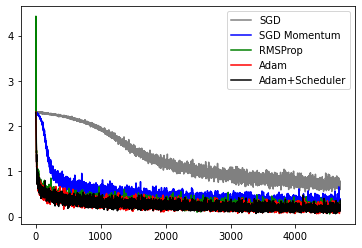

In [ ]:
plt.plot(
    np.arange(len(train_dataloader) * 10),
    sgd_loss_info.full_train_losses,
    label="SGD",
    c="grey",
)
plt.plot(
    np.arange(len(train_dataloader) * 10),
    sgd_momentum_loss_info.full_train_losses,
    label="SGD Momentum",
    c="blue",
)
plt.plot(
    np.arange(len(train_dataloader) * 10),
    rmsprop_loss_info.full_train_losses,
    label="RMSProp",
    c="green",
)
plt.plot(
    np.arange(len(train_dataloader) * 10),
    adam_loss_info.full_train_losses,
    label="Adam",
    c="red",
)
plt.plot(
    np.arange(len(train_dataloader) * 10),
    adam_scheduler_loss_info.full_train_losses,
    label="Adam+Scheduler",
    c="black",
)

plt.legend()
plt.show()

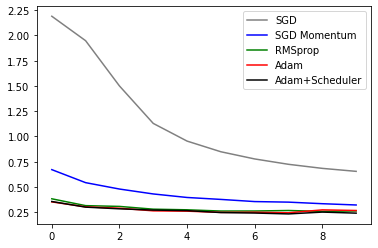

In [ ]:
plt.plot(np.arange(10), sgd_loss_info.eval_epoch_losses, label="SGD", c="grey")
plt.plot(
    np.arange(10),
    sgd_momentum_loss_info.eval_epoch_losses,
    label="SGD Momentum",
    c="blue",
)
plt.plot(np.arange(10), rmsprop_loss_info.eval_epoch_losses, label="RMSprop", c="green")
plt.plot(np.arange(10), adam_loss_info.eval_epoch_losses, label="Adam", c="red")
plt.plot(
    np.arange(10),
    adam_scheduler_loss_info.eval_epoch_losses,
    label="Adam+Scheduler",
    c="black",
)
plt.legend()
plt.show()